In [1]:
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from mordred import descriptors, Calculator
from PIL import Image

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

# regression metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classification metrics
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

from ngboost import NGBRegressor, NGBClassifier
from ngboost.distns import Bernoulli

## Create combinatorial library

In [56]:
def mfs(s):
    return Chem.MolFromSmiles(s)

def mts(m):
    return Chem.MolToCXSmiles(m)

def sanitize_smiles(smi):
    m = Chem.MolFromSmiles(smi) 
    Chem.SanitizeMol(m)
    return Chem.MolToSmiles(m)

def sonogashira(smi_template, smi_alkyne):
    mol1 = Chem.MolFromSmiles(smi_template)
    mol2 = Chem.MolFromSmiles(smi_alkyne)
    smarts = "[#6:1]-[I,Br,Cl].[C:2]#[$([CH1]),$([#6X2][Si])]>>[*:1]C#[C:2]"
    rxn = AllChem.ReactionFromSmarts(smarts)
    reacts = (mol1, mol2)
    products = rxn.RunReactants(reacts) # tuple
    p = products[0][0]
    Chem.SanitizeMol(p)
    return p

In [57]:
df_templates = pd.read_csv('template_frags.csv').iloc[:10, :]
df_alkynes = pd.read_csv('alkyne_frags.csv').iloc[:27, :]

print('NUM TEMPLATE FRAGS : ', df_templates.shape[0])
print('NUM ALKYNE FRAGS : ', df_alkynes.shape[0])

NUM TEMPLATE FRAGS :  10
NUM ALKYNE FRAGS :  27


In [64]:
mols = []
templates_smi = []
alkynes_smi = []
templates_name = []
alkynes_name = []

for i_tem in df_templates.index:
    for i_alk in df_alkynes.index:
        smi_tem = df_templates.loc[i_tem, 'smiles']
        smi_alk = df_alkynes.loc[i_alk, 'smiles']
        
        name_tem = df_templates.loc[i_tem, 'name']
        name_alk = df_alkynes.loc[i_alk, 'name']
        
        # react
        p = sonogashira(smi_tem, smi_alk)
        
        # append info
        mols.append(p)
        templates_smi.append(sanitize_smiles(smi_tem))
        alkynes_smi.append(sanitize_smiles(smi_alk))
        templates_name.append(name_tem)
        alkynes_name.append(name_alk)
        
# canon smiles
templates_smi = [Chem.CanonSmiles(s) for s in templates_smi]
alkynes_smi = [Chem.CanonSmiles(s) for s in alkynes_smi]

In [67]:
# generate dataframe including the reactant and product smiles
d = {'template_name':templates_name, 'alkyne_name':alkynes_name, 
     'template_smi':templates_smi, 'alkyne_smi':alkynes_smi, 
     'molecule_smi':[Chem.MolToSmiles(m) for m in mols]}
df = pd.DataFrame(d)
print(df.shape)
print(df.columns)
df.head()

(270, 5)
Index(['template_name', 'alkyne_name', 'template_smi', 'alkyne_smi',
       'molecule_smi'],
      dtype='object')


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...


In [70]:
# load IC50s
df_results = pd.read_csv('exp_results.csv').iloc[:96, :]
df_results = df_results.rename(columns={'template':'template_name', 'alkyne':'alkyne_name'})
ic50 = df_results.loc[:, 'abl1_ic50_nM'].to_numpy()
# take log of IC50 values
df_results.loc[:, 'abl1_pIC50'] = - np.log10(ic50 * 10**(-9))
# combine the two dataframes
df_merged = df.merge(df_results, on=['template_name', 'alkyne_name'])
df_reg = df_merged.drop(columns=['synthesis_order', 'abl1_ic50_nM', 'abl2_ic50_nM'])
df_reg = df_reg.dropna()
print(df_merged.shape)
print(df_reg.shape)
print(df_reg.columns)
df_reg.head()

(96, 10)
(71, 7)
Index(['template_name', 'alkyne_name', 'template_smi', 'alkyne_smi',
       'molecule_smi', 'synthesis_success', 'abl1_pIC50'],
      dtype='object')


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,abl1_pIC50
0,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,8.045757
2,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,8.065502
3,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,9.698970
4,8-1,22-6,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cnccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,8.638272
5,8-1,22-7,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncn1C,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,yes,7.045757


In [81]:
molecule_smiles = df_reg.molecule_smi.tolist()
molecule_mols = [mfs(s) for s in molecule_smiles]

# get the unique template and alkyne names/smiles/mols
df_template_uniq = df.drop_duplicates(subset=['template_name'])
template_names_uniq = df_template_uniq.template_name.tolist()
template_smi_uniq = df_template_uniq.template_smi.tolist()
template_mols_uniq = [mfs(s) for s in template_smi_uniq]

df_alkyne_uniq = df.drop_duplicates(subset=['alkyne_name'])
alkyne_names_uniq = df_alkyne_uniq.alkyne_name.tolist()
alkyne_smi_uniq = df_alkyne_uniq.alkyne_smi.tolist()
alkyne_mols_uniq = [mfs(s) for s in alkyne_smi_uniq]


for i in [template_names_uniq, template_smi_uniq, template_mols_uniq]:
    assert len(i)==10 

for i in [alkyne_names_uniq, alkyne_smi_uniq, alkyne_mols_uniq]:
    assert len(i)==27

In [83]:
def compute_mordred(names, smiles, mols):
    calc = Calculator(descriptors, ignore_3D=True)
    df_mord_tmp = calc.pandas(mols)

    df_mord_tmp = df_mord_tmp.select_dtypes(exclude=['O', 'bool'])

    # remove descriptors that have zero variance over all fragments
    num_unique = df_mord_tmp.apply(pd.Series.nunique)
    df_mord_tmp = df_mord_tmp.drop(num_unique[num_unique==1].index, axis=1)
    
    df_mord_tmp['smiles'] = smiles
    df_mord_tmp['name']   = names
    cols = ['name', 'smiles']+df_mord_tmp.columns[:-2].tolist()
    
    return df_mord_tmp[cols]

In [91]:
template_mord = compute_mordred(template_names_uniq, template_smi_uniq, template_mols_uniq)
alkyne_mord = compute_mordred(alkyne_names_uniq, alkyne_smi_uniq, alkyne_mols_uniq)

print('NUM TEMPLATE MORDRED :', template_mord.shape[1]-2)
print('NUM ALKYNE MORDRED :', alkyne_mord.shape[1]-2)
template_mord.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.43it/s]


NUM TEMPLATE MORDRED : 1156
NUM ALKYNE MORDRED : 1078


,name,smiles,ABC,ABCGG,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,8-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,22.651695,17.587335,2,36.062380,2.419969,4.839939,36.062380,1.243530,...,10.271355,64.553071,517.083795,9.943919,2432,45,152.0,175.0,11.062500,6.166667
1,8-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,23.956519,18.245356,2,38.676148,2.420612,4.841224,38.676148,1.247618,...,10.304844,66.772570,547.094360,9.769542,3010,48,160.0,184.0,11.562500,6.750000
2,8-3,Cc1ccc(C(=O)Nc2ccc(CN3CCC(O)CC3)c(C(F)(F)F)c2)...,22.651695,17.587335,1,36.062380,2.419969,4.839939,36.062380,1.243530,...,10.271355,64.553071,518.067811,10.158192,2432,45,152.0,175.0,11.062500,6.166667
3,8-4,Cc1ccc(C(=O)Nc2ccc(Cn3ccnc3)c(C(F)(F)F)c2)cc1I,21.128092,17.246066,0,33.701998,2.420005,4.834242,33.701998,1.248222,...,10.186747,75.276506,485.021195,11.548124,1967,40,142.0,164.0,9.951389,5.750000
4,8-5,Cc1ccc(C(=O)Nc2ccccc2)cc1I,12.975211,10.960672,0,21.721891,2.324025,4.648050,21.721891,1.277758,...,9.524932,49.322071,336.996362,11.620564,554,23,84.0,95.0,5.805556,3.805556


In [168]:
template_mord['C1SP2']

0    1
1    1
2    1
3    3
4    1
5    1
6    1
7    1
8    3
9    2
Name: C1SP2, dtype: int64

0     4
1     3
2     3
3     3
4     5
5     5
6     1
7     1
8     3
9     1
10    3
11    2
12    2
13    2
14    2
15    2
16    0
17    0
18    0
19    0
20    2
21    2
22    2
23    0
24    4
25    2
26    2
Name: C1SP2, dtype: int64

## PCA explained variance analysis on reactant descriptors

In [116]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [117]:
def make_pca_analysis(df, num_components=100, skipcols=2):
    
    X  = df.iloc[:, skipcols:].values
    df_info = df.iloc[:, :skipcols]
    names = df.name.tolist()
    
    #print(X.shape)
    
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X)
    
    pca = PCA(n_components=num_components)
    X_red = pca.fit_transform(X_norm)
    
    #print(X_red.shape)
    
    exp_var = pca.explained_variance_ratio_
    cum_exp_var = exp_var.cumsum()
    
    # return also a dataframe of the components
    sub = pd.DataFrame(X_red, columns=[f'pc_{i}' for i in range(X_red.shape[1])])
    sub['name'] = names
    cols = ['name']+sub.columns.tolist()[:-1]
    sub = sub[cols]
    
    #df_red = pd.concat((df_info, sub), axis=1, ignore_index=True)
    
    #print(df_info.shape, sub.shape)
    #print(df_red.shape)
    #print(df_info.head())
    #print(sub.head())
    
    return X_red, sub, exp_var, cum_exp_var
    
    

In [118]:
X_red_temp, df_red_temp, exp_var_temp, cum_exp_var_temp = make_pca_analysis(template_mord, num_components=10)
X_red_alky, df_red_alky, exp_var_alky, cum_exp_var_alky = make_pca_analysis(alkyne_mord, num_components=20)

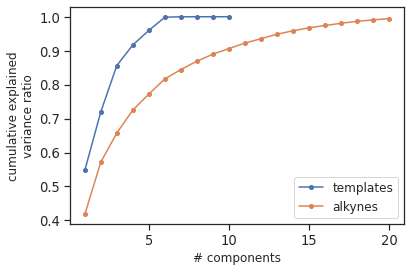

In [119]:
fig, ax = plt.subplots()

ax.plot(np.arange(cum_exp_var_temp.shape[0])+1, cum_exp_var_temp, marker='o', markersize=4, label='templates')
ax.plot(np.arange(cum_exp_var_alky.shape[0])+1, cum_exp_var_alky, marker='o', markersize=4, label='alkynes')

ax.set_xlabel('# components', fontsize=12)
ax.set_ylabel('cumulative explained\nvariance ratio', fontsize=12)

ax.legend(loc='lower right', fontsize=12)

ax.set_facecolor('w')
plt.savefig('pca_exp_var_ratio_reduced.png', dpi=300)

In [121]:
# save the PCA descriptors to disk
df_red_temp.to_csv('descriptors/template_pca_desc.csv', index=False)
df_red_alky.to_csv('descriptors/alkyne_pca_desc.csv', index=False)

In [124]:
template_mord.to_csv('descriptors/template_mord_desc.csv', index=False)
alkyne_mord.to_csv('descriptors/alkyne_mord_desc.csv', index=False)

## Add descriptors to the full dataset - this is just for checking the correlations

In [100]:
# load in the dataset including the predicted data
df_all = pd.read_csv('lookup_table.csv')
print(df_all.shape)
df_all.head()

(270, 10)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...,1,0.536046,0,7.390089,7.156328
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0,0.000000,1,7.515735,7.152991
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000


In [163]:
template_descs = []
alkyne_descs = []

for ix, row in df_all.iterrows():
    row = row.to_dict()
    template_name = row['template_name']
    alkyne_name = row['alkyne_name']

    # lookup the corresponding descriptors
    desc_template = template_mord[template_mord.name==template_name].iloc[0, 2:].to_dict()
    desc_template_ = {}
    for key, val in desc_template.items():
        desc_template_['_'.join(['_template', key])] = val

    desc_alkyne = alkyne_mord[alkyne_mord.name==alkyne_name].iloc[0, 2:].to_dict()
    desc_alkyne_ = {}
    for key, val in desc_alkyne.items():
        desc_alkyne_['_'.join(['_alkyne', key])] = val
        
    # pca template
    desc_template_pca = df_red_temp[df_red_temp.name==template_name].iloc[0, 1:].to_dict()
    desc_template_pca_ = {}
    for key, val in desc_template_pca.items():
        desc_template_pca_['_'.join(['_template', key])] = val
        
    # pca alkyne
    desc_alkyne_pca = df_red_alky[df_red_alky.name==alkyne_name].iloc[0, 1:].to_dict()
    desc_alkyne_pca_ = {}
    for key, val in desc_alkyne_pca.items():
        desc_alkyne_pca_['_'.join(['_alkyne', key])] = val
    

    template_descs.append(desc_template_)
    template_descs.append(desc_template_pca_)
    alkyne_descs.append(desc_alkyne_)
    alkyne_descs.append(desc_alkyne_pca_)
    
    print(desc_alkyne_pca_)
        
        
template_descs_ = pd.DataFrame(template_descs)
alkyne_descs_ = pd.DataFrame(alkyne_descs)


print(template_descs_.shape, alkyne_descs_.shape, df_all.shape)

{'_alkyne_pc_0': 31.23684159617959, '_alkyne_pc_1': 15.129010012079553, '_alkyne_pc_2': -3.1746476648718764, '_alkyne_pc_3': -0.13767171991188795, '_alkyne_pc_4': 16.522459276808323, '_alkyne_pc_5': 15.045283317515503, '_alkyne_pc_6': -5.8568994665285725, '_alkyne_pc_7': -2.0722455921681573, '_alkyne_pc_8': 11.099442812874509, '_alkyne_pc_9': 3.9568560444183944, '_alkyne_pc_10': -5.773415517139303, '_alkyne_pc_11': -1.2987929412594579, '_alkyne_pc_12': -1.8629700637467295, '_alkyne_pc_13': 4.426903286411537, '_alkyne_pc_14': -0.8065959073373526, '_alkyne_pc_15': -1.447755887920348, '_alkyne_pc_16': 0.014756668064274859, '_alkyne_pc_17': 0.09479084458095137, '_alkyne_pc_18': -0.21136237418426662, '_alkyne_pc_19': -0.6783029232777216}
{'_alkyne_pc_0': 1.671221159525173, '_alkyne_pc_1': 4.680084279036454, '_alkyne_pc_2': -10.157216503794203, '_alkyne_pc_3': -0.7437771878159619, '_alkyne_pc_4': 3.0756701103237907, '_alkyne_pc_5': -2.8510717274288266, '_alkyne_pc_6': -5.814138239433165, '_a

{'_alkyne_pc_0': 26.66184884281421, '_alkyne_pc_1': -0.21424003901328892, '_alkyne_pc_2': -2.1153650111965105, '_alkyne_pc_3': 23.11856174802214, '_alkyne_pc_4': 0.4116657344511581, '_alkyne_pc_5': 14.536086049713472, '_alkyne_pc_6': 7.67373286278489, '_alkyne_pc_7': -8.915994671927773, '_alkyne_pc_8': -8.052280809910663, '_alkyne_pc_9': -1.1120071032524685, '_alkyne_pc_10': 4.673409638002532, '_alkyne_pc_11': 0.7661301836920411, '_alkyne_pc_12': 4.988532744126736, '_alkyne_pc_13': -0.44702151285473263, '_alkyne_pc_14': -2.1800988838291055, '_alkyne_pc_15': 0.9981025678312844, '_alkyne_pc_16': -2.596463139468429, '_alkyne_pc_17': -0.03369383336845949, '_alkyne_pc_18': -0.08956241312640771, '_alkyne_pc_19': -0.13838185600915667}
{'_alkyne_pc_0': -11.924589000444968, '_alkyne_pc_1': -3.2555286573041924, '_alkyne_pc_2': 6.994751358140207, '_alkyne_pc_3': 2.319185470088656, '_alkyne_pc_4': 3.5698889544422676, '_alkyne_pc_5': 12.538584088738055, '_alkyne_pc_6': 6.441522298688754, '_alkyne_p

{'_alkyne_pc_0': -18.36202936147284, '_alkyne_pc_1': -2.309525112556782, '_alkyne_pc_2': 2.490535943896667, '_alkyne_pc_3': -15.679022726994587, '_alkyne_pc_4': 19.175952755640445, '_alkyne_pc_5': 0.6728100109340233, '_alkyne_pc_6': -0.04079404515613882, '_alkyne_pc_7': -2.3475452665362084, '_alkyne_pc_8': -0.11397612324083067, '_alkyne_pc_9': -4.220791776794196, '_alkyne_pc_10': 4.388592084844874, '_alkyne_pc_11': 2.7487639227795486, '_alkyne_pc_12': 9.263742011200712, '_alkyne_pc_13': -4.981307332851852, '_alkyne_pc_14': 2.8840570306658626, '_alkyne_pc_15': -0.43131229018046047, '_alkyne_pc_16': 1.3697205326783075, '_alkyne_pc_17': -2.2496812739644945, '_alkyne_pc_18': -1.562228918011494, '_alkyne_pc_19': 0.7303882980077202}
{'_alkyne_pc_0': -21.018289699590657, '_alkyne_pc_1': -5.902583610811939, '_alkyne_pc_2': 0.6111640527478718, '_alkyne_pc_3': 2.103170755741683, '_alkyne_pc_4': 5.768859234098941, '_alkyne_pc_5': -4.950120749416748, '_alkyne_pc_6': -2.01733101676727, '_alkyne_pc_

{'_alkyne_pc_0': -8.988791890660393, '_alkyne_pc_1': -3.764276477883547, '_alkyne_pc_2': 4.84519910582838, '_alkyne_pc_3': 11.223180476043948, '_alkyne_pc_4': -5.255356309774053, '_alkyne_pc_5': 0.1045982083966928, '_alkyne_pc_6': -5.7976000554889096, '_alkyne_pc_7': 0.19023950222015648, '_alkyne_pc_8': 8.411879532453616, '_alkyne_pc_9': -2.671280441176034, '_alkyne_pc_10': -1.0141438614609113, '_alkyne_pc_11': 13.812677602599571, '_alkyne_pc_12': -2.7562133590099083, '_alkyne_pc_13': -3.2790921031801137, '_alkyne_pc_14': -0.4262658796938456, '_alkyne_pc_15': 3.570594718719732, '_alkyne_pc_16': -0.9096807068265617, '_alkyne_pc_17': -2.1285405143392007, '_alkyne_pc_18': 1.0680378738662022, '_alkyne_pc_19': 1.29826362417143}
{'_alkyne_pc_0': -12.995339366770192, '_alkyne_pc_1': 0.25860783869330706, '_alkyne_pc_2': 14.403906735923535, '_alkyne_pc_3': 6.275985980312315, '_alkyne_pc_4': -8.118223603934956, '_alkyne_pc_5': -1.2111789939344322, '_alkyne_pc_6': -3.0886176300183568, '_alkyne_pc

{'_alkyne_pc_0': 49.487696730387285, '_alkyne_pc_1': -30.40298442835146, '_alkyne_pc_2': 3.253574475960927, '_alkyne_pc_3': -5.49066836096949, '_alkyne_pc_4': -2.7217399700636333, '_alkyne_pc_5': -4.818975435656928, '_alkyne_pc_6': 2.5656919416564405, '_alkyne_pc_7': 3.202979817787425, '_alkyne_pc_8': 6.050945455838781, '_alkyne_pc_9': 0.38131190855043157, '_alkyne_pc_10': -3.3711228284435952, '_alkyne_pc_11': -5.5764823766137175, '_alkyne_pc_12': 1.7290561181733615, '_alkyne_pc_13': -6.007543810722512, '_alkyne_pc_14': -2.3364430394565674, '_alkyne_pc_15': 1.6837104032542711, '_alkyne_pc_16': -4.3125943467215535, '_alkyne_pc_17': 0.20395297599995088, '_alkyne_pc_18': -1.2017545105704996, '_alkyne_pc_19': 2.276052065588355}
{'_alkyne_pc_0': -16.536377653985397, '_alkyne_pc_1': -9.13051801812823, '_alkyne_pc_2': 4.32621145282401, '_alkyne_pc_3': -22.281141792916195, '_alkyne_pc_4': -13.28430291464749, '_alkyne_pc_5': 17.875935540253487, '_alkyne_pc_6': -4.946826798785743, '_alkyne_pc_7'

In [160]:
# join dfs
df_all_w_desc = pd.concat((df_all, template_descs_, alkyne_descs_), axis=1)
print(df_all_w_desc.shape)
# reduce the df to the experimental measurements (and some which are predicted :() )
df_all_w_desc = df_all_w_desc[df_all_w_desc.is_experiment_x==1]
print(df_all_w_desc.shape)
df_all_w_desc.head()

(540, 2274)
(96, 2274)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std,...,_alkyne_pc_10,_alkyne_pc_11,_alkyne_pc_12,_alkyne_pc_13,_alkyne_pc_14,_alkyne_pc_15,_alkyne_pc_16,_alkyne_pc_17,_alkyne_pc_18,_alkyne_pc_19
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1.0,1.0,1.0,8.045757,1.000000,...,-5.773416,-1.298793,-1.862970,4.426903,-0.806596,-1.447756,0.014757,0.094791,-0.211362,-0.678303
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0.0,0.0,1.0,7.515735,7.152991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1.0,1.0,1.0,8.065502,1.000000,...,1.417855,0.054285,-2.896101,-2.186081,-2.392777,-1.117300,2.090578,3.105760,-1.992305,3.104539
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1.0,1.0,1.0,9.698970,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8-1,22-6,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cnccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1.0,1.0,1.0,8.638272,1.000000,...,4.131317,-0.571109,-4.101944,-0.886905,-0.411722,-0.621316,0.093759,0.029182,0.295611,0.187829


In [161]:
# measure the correlations 
temp_cols = [col for col in df_all_w_desc.columns.tolist() if col.startswith('_template')]
alky_cols = [col for col in df_all_w_desc.columns.tolist() if col.startswith('_alkyne')]

In [162]:
PROPS = ['abl1_pIC50']
corrs = []

# templates
for prop in PROPS:
    prop_vals = df_all_w_desc[prop].values
    for col in temp_cols:
        desc_vals = df_all_w_desc[col].values.astype(np.float32)

        corr = pearsonr(prop_vals.ravel(), desc_vals.ravel())[0]
        
        corrs.append(
            {
                'prop': prop,
                'desc': col,
                'frag_type': 'template',
                'corr': corr,
            }
        )

# alkynes
for prop in PROPS:
    prop_vals = df_all_w_desc[prop].values
    for col in alky_cols:
        desc_vals = df_all_w_desc[col].values.astype(np.float32)

        corr = pearsonr(prop_vals.ravel(), desc_vals.ravel())[0]
        
        corrs.append(
            {
                'prop': prop,
                'desc': col,
                'frag_type': 'alkyne',
                'corr': corr,
            }
        )

        
df_corr = pd.DataFrame(corrs)
print('df_corr shape : ', df_corr.shape)
df_corr.head()

ValueError: array must not contain infs or NaNs

In [166]:
# visualize the correlationso the the "inutitive" descriptors
# list re-generated by RH on Sept 14, 2021 (add DFT stuff)
intuitive_desc = [
    'nHeavyAtom', 'nHetero',
    'C1SP1', 'C2SP1', 'C1SP2', 'C2SP2', 'C3SP2', 'C1SP3', 'C2SP3', 'HybRatio', 'HBAcc', 'nHBDon', 
    'apol', 'bpol', 'nRot', 'RotRatio', 'TopoPSA', 'Diameter', 'Radius', 'MW',
]
print(len(intuitive_desc))

pca_desc_temp = [f'pc_{i}' for i in range(10)]
pca_desc_alky = [f'pc_{i}' for i in range(20)]


# add the fragment prefix
t = ['_'.join(['_template', d]) for d in intuitive_desc]
a = ['_'.join(['_alkyne', d]) for d in intuitive_desc]

intuitive_desc = t+a


20


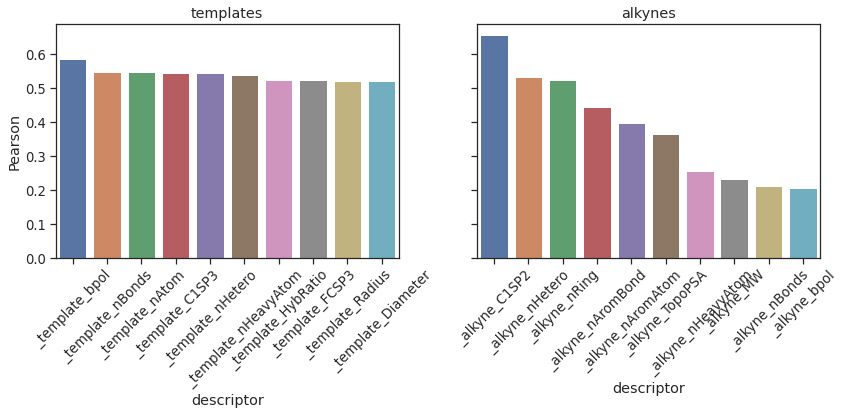

In [157]:
# INTUITIVE DESCRIPTORS
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

intuit_corrs = df_corr[df_corr['desc'].isin(intuitive_desc)]


# plot template correlations (top 10)
sub = intuit_corrs[intuit_corrs.frag_type=='template'].sort_values(by='corr', ascending=False).iloc[:10,:]

b_  = sns.barplot(data=sub, x='desc', y='corr', ax=axes[0])
axes[0].set_title(f'templates')
axes[0].tick_params(axis='x', rotation=45)

axes[0].set_xlabel('descriptor')
axes[0].set_ylabel('Pearson')


# plot the alkyne correlations (top 10)

sub = intuit_corrs[intuit_corrs.frag_type=='alkyne'].sort_values(by='corr', ascending=False).iloc[:10,:]

b_  = sns.barplot(data=sub, x='desc', y='corr', ax=axes[1])
axes[1].set_title(f'alkynes')
axes[1].tick_params(axis='x', rotation=45)

axes[1].set_xlabel('descriptor')
axes[1].set_ylabel('')


plt.tight_layout()
plt.savefig('mordred_intuit_corrs.png', dpi=300)

In [ ]:
template_mord.to_csv('descriptors/template_mord_desc.csv', index=False)
alkyne_mord.to_csv('descriptors/alkyne_mord_desc.csv', index=False)

In [2]:
template_mord = pd.read_csv('descriptors/template_mord_desc.csv')
alkyne_mord = pd.read_csv('descriptors/alkyne_mord_desc.csv')

In [3]:
template_mord

,name,smiles,ABC,ABCGG,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,8-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,22.651695,17.587335,2,36.062380,2.419969,4.839939,36.062380,1.243530,...,10.271355,64.553071,517.083795,9.943919,2432,45,152.0,175.0,11.062500,6.166667
1,8-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,23.956519,18.245356,2,38.676148,2.420612,4.841224,38.676148,1.247618,...,10.304844,66.772570,547.094360,9.769542,3010,48,160.0,184.0,11.562500,6.750000
2,8-3,Cc1ccc(C(=O)Nc2ccc(CN3CCC(O)CC3)c(C(F)(F)F)c2)...,22.651695,17.587335,1,36.062380,2.419969,4.839939,36.062380,1.243530,...,10.271355,64.553071,518.067811,10.158192,2432,45,152.0,175.0,11.062500,6.166667
3,8-4,Cc1ccc(C(=O)Nc2ccc(Cn3ccnc3)c(C(F)(F)F)c2)cc1I,21.128092,17.246066,0,33.701998,2.420005,4.834242,33.701998,1.248222,...,10.186747,75.276506,485.021195,11.548124,1967,40,142.0,164.0,9.951389,5.750000
4,8-5,Cc1ccc(C(=O)Nc2ccccc2)cc1I,12.975211,10.960672,0,21.721891,2.324025,4.648050,21.721891,1.277758,...,9.524932,49.322071,336.996362,11.620564,554,23,84.0,95.0,5.805556,3.805556
5,16-1,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,22.651695,17.597665,2,36.046581,2.427520,4.855041,36.046581,1.242986,...,10.271355,64.553071,517.083795,9.943919,2422,45,152.0,175.0,11.062500,6.166667
6,16-2,Cc1ccc(NC(=O)c2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,23.956519,18.256451,2,38.639178,2.428089,4.856178,38.639178,1.246425,...,10.304844,66.772570,547.094360,9.769542,2998,48,160.0,184.0,11.562500,6.750000
7,16-3,Cc1ccc(NC(=O)c2ccc(CN3CCC(O)CC3)c(C(F)(F)F)c2)...,22.651695,17.597665,1,36.046581,2.427520,4.855041,36.046581,1.242986,...,10.271355,64.553071,518.067811,10.158192,2422,45,152.0,175.0,11.062500,6.166667
8,16-4,Cc1ccc(NC(=O)c2ccc(Cn3ccnc3)c(C(F)(F)F)c2)cc1I,21.128092,17.255421,0,33.592815,2.427596,4.849832,33.592815,1.244178,...,10.186747,75.276506,485.021195,11.548124,1959,40,142.0,164.0,9.951389,5.750000
9,19,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,22.692135,17.955467,2,35.466846,2.416331,4.830738,35.466846,1.222995,...,10.215850,78.332802,474.099056,9.296060,2494,42,152.0,174.0,11.062500,6.138889


In [22]:
template_8_1_smiles = template_mord[template_mord['name']=='8-1'].to_dict('r')[0]['smiles']
template_8_1_smiles

/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  """Entry point for launching an IPython kernel.


'Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1I'

In [23]:
template_16_1_smiles = template_mord[template_mord['name']=='16-1'].to_dict('r')[0]['smiles']
template_16_1_smiles

/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  """Entry point for launching an IPython kernel.


'Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1I'

In [27]:
template_8_1_desc = template_mord[template_mord['name']=='8-1'].iloc[0, 2:]
template_16_1_desc = template_mord[template_mord['name']=='16-1'].iloc[0, 2:]

In [32]:
bools = template_8_1_desc==template_16_1_desc
idxs = np.where(~bools)[0]
idxs

array([   1,    3,    4,    5,    6,    7,    8,    9,   10,   11,   12,
         13,   14,   33,   34,   35,   36,   41,   42,   43,   44,   45,
         49,   50,   51,   52,   53,   54,   59,   60,   61,   62,   63,
         64,   67,   68,   69,   70,   71,   72,   76,   77,   78,   79,
         80,   81,   83,   86,   87,   88,   89,   90,   91,   92,   95,
         96,   97,   98,   99,  101,  102,  104,  105,  106,  107,  108,
        113,  114,  115,  116,  117,  122,  123,  124,  125,  126,  132,
        133,  134,  135,  140,  141,  142,  143,  144,  148,  149,  150,
        151,  152,  153,  158,  159,  160,  161,  162,  163,  167,  168,
        169,  170,  171,  174,  176,  177,  178,  179,  180,  182,  184,
        185,  186,  187,  188,  189,  190,  191,  194,  195,  196,  197,
        198,  200,  201,  203,  204,  205,  206,  207,  212,  213,  214,
        215,  216,  219,  221,  222,  223,  224,  225,  226,  227,  228,
        229,  230,  231,  232,  233,  234,  236,  2

In [35]:
bools[idxs]

ABCGG       False
SpAbs_A     False
SpMax_A     False
SpDiam_A    False
SpAD_A      False
            ...  
MWC08       False
MWC09       False
MWC10       False
TMWC10      False
WPath       False
Length: 684, dtype: bool

In [48]:
template_mord.iloc[:, np.concatenate((np.array([0, 1]), idxs+2))]

,name,smiles,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,JGI9,JGI10,JGT10,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,WPath
0,8-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,17.587335,36.062380,2.419969,4.839939,36.062380,1.243530,4.287476,4.474467,...,0.011528,0.008251,0.567833,8.476996,9.337061,10.218116,11.083142,11.964249,136.310235,2432
1,8-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,18.245356,38.676148,2.420612,4.841224,38.676148,1.247618,4.348364,4.530771,...,0.011914,0.008680,0.539055,8.520189,9.379492,10.259237,11.123594,12.003742,140.709157,3010
2,8-3,Cc1ccc(C(=O)Nc2ccc(CN3CCC(O)CC3)c(C(F)(F)F)c2)...,17.587335,36.062380,2.419969,4.839939,36.062380,1.243530,4.287476,4.474467,...,0.011528,0.008251,0.567833,8.476996,9.337061,10.218116,11.083142,11.964249,136.310235,2432
3,8-4,Cc1ccc(C(=O)Nc2ccc(Cn3ccnc3)c(C(F)(F)F)c2)cc1I,17.246066,33.701998,2.420005,4.834242,33.701998,1.248222,4.220859,4.386003,...,0.012059,0.008458,0.545902,8.418256,9.279773,10.163272,11.029342,11.912701,131.777330,1967
4,8-5,Cc1ccc(C(=O)Nc2ccccc2)cc1I,10.960672,21.721891,2.324025,4.648050,21.721891,1.277758,3.746700,3.733339,...,0.011406,0.012346,0.460381,7.755767,8.589142,9.429556,10.265523,11.106865,104.847538,554
5,16-1,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,17.597665,36.046581,2.427520,4.855041,36.046581,1.242986,4.287476,4.404592,...,0.010417,0.009625,0.569330,8.478244,9.337942,10.221614,11.085813,11.970762,136.325045,2422
6,16-2,Cc1ccc(NC(=O)c2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,18.256451,38.639178,2.428089,4.856178,38.639178,1.246425,4.348364,4.458632,...,0.010977,0.009726,0.540292,8.521384,9.380336,10.262595,11.126159,12.010003,140.723380,2998
7,16-3,Cc1ccc(NC(=O)c2ccc(CN3CCC(O)CC3)c(C(F)(F)F)c2)...,17.597665,36.046581,2.427520,4.855041,36.046581,1.242986,4.287476,4.404592,...,0.010417,0.009625,0.569330,8.478244,9.337942,10.221614,11.085813,11.970762,136.325045,2422
8,16-4,Cc1ccc(NC(=O)c2ccc(Cn3ccnc3)c(C(F)(F)F)c2)cc1I,17.255421,33.592815,2.427596,4.849832,33.592815,1.244178,4.220859,4.320789,...,0.011790,0.008287,0.546459,8.419580,9.280706,10.166967,11.032160,11.919557,131.792955,1959
9,19,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,17.955467,35.466846,2.416331,4.830738,35.466846,1.222995,4.288543,4.383568,...,0.007968,0.012833,0.579313,8.471568,9.325186,10.209095,11.068340,11.951251,136.238948,2494


In [51]:
# for i in template_mord.iloc[:, np.concatenate((np.array([0, 1]), idxs+2))].columns:
#     print(i)